# Some experiments with OpenCV

In [1]:
import cv2
import io
import numpy as np
import urllib.request
import pandas as pd

from PIL import Image as PImage

In [2]:
# helper functions to convert between PIL and OpenCV image types

def tocv(pil):
  return np.array(pil)

def topil(cv):
  return PImage.fromarray(cv)

## Open an Image

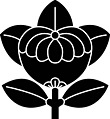

In [12]:
# open image from url
img = PImage.open("random_subset/plant_tachibana_31.jpg")


# this makes the largest edge of the image be 480
img.thumbnail((480, 480))
display(img)

## Threshold

Turn color/gray image into black and white

Doc: https://docs.opencv.org/4.x/db/d8e/tutorial_threshold.html

Image is already grayscale.


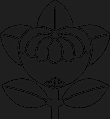

In [31]:
img_cv = tocv(img)

# Check the number of channels before converting
if len(img_cv.shape) == 3:  # If the image has 3 channels (BGR)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    print("Converted to grayscale.")
else:  # The image is already grayscale
    img_cv = img_cv
    print("Image is already grayscale.")

topil(img_cv)

In [32]:
# opencv functions take raw pixel arrays and not PIL images 🤷

img_cv = tocv(img)

ret, img_thold_cv = cv2.threshold(cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY), 128, 255, cv2.THRESH_BINARY)

display(topil(img_thold_cv))

#not neccesary for Kamons, which are black and white

error: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-15:Bad number of channels) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4>, cv::impl::(anonymous namespace)::Set<1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>>::CvtHelper(InputArray, OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4>, VDcn = cv::impl::(anonymous namespace)::Set<1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


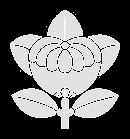

In [ ]:
#adding white background and adding border_size = 10
#and invert


if len(img_cv.shape) == 2:  # Grayscale images have 2 dimensions

    # Create a mask for non-black pixels (pixel value > 0)

    mask = img_cv > 30

    # Set all non-black pixels to white (255)
    img_cv[mask] = 255

    img_cv = cv2.copyMakeBorder(img_cv, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=255)

    img_cv = cv2.bitwise_not(img_cv)

    # Display the modified image
    display(topil(img_cv))
else:
    print("The image is not in grayscale format.")

USE threshold() for turning to complete black and white 128

In [ ]:
#look into this image a bit
type(img_cv)
image_pixels = list(img.getdata())
#what values are present here? using pandas value_counts
image_pixels_df = pd.DataFrame(image_pixels, columns=['pixel'])
image_pixels_df.value_counts()



In [ ]:
#invert image colors
# use bitwise_not from cv2
inverted_cv = cv2.bitwise_not(img_cv)
img_cv = inverted_cv
topil(img_cv)


In [ ]:
eksize = 2
ekernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2 * eksize + 1, 2 * eksize + 1), (eksize, eksize))
eroded_cv = cv2.erode(img_cv, ekernel)
display(topil(eroded_cv))

In [ ]:
inverted_eroded_cv = cv2.bitwise_not(img_cv)
topil(inverted_eroded_cv)

## Erode / Dilate

Reduces / Expands white regions on the image, respectively.

By applying complementary erode/dilate operations you can get rid of gaps and concave parts of an image.

Doc: https://docs.opencv.org/4.x/db/df6/tutorial_erosion_dilatation.html

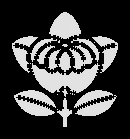

In [17]:
# this sets up the shape and size of the erosion filter
eksize = 2
ekernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2 * eksize + 1, 2 * eksize + 1), (eksize, eksize))

dksize = 5
dkernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (2 * dksize + 1, 2 * dksize + 1), (dksize, dksize))

eroded_cv = cv2.erode(img_cv, ekernel)
dilated_cv = cv2.dilate(eroded_cv, dkernel)

display(topil(eroded_cv))

## Extracting Outline

The function for this is called `findContours()`.

Docs: https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html

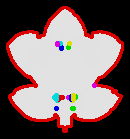

In [36]:
colors = [(220,0,0),(0,220,0),(0,0,220),(220,220,0),(0,220,220),(220,0,220)]

draw_cv = cv2.cvtColor(dilated_cv.copy(), cv2.COLOR_GRAY2RGB)

contours, hierarchy = cv2.findContours(image=dilated_cv, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

if contours:
  for idx,con in enumerate(contours):
    cv2.drawContours(draw_cv, [con], 0, colors[idx%len(colors)], 2)

display(PImage.fromarray(draw_cv))

"In OpenCV, finding contours is like finding white object from black background. So remember, object to be found should be white and background should be black." https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html

Maybe should try inverting colors and see if contours are picked up better?

In [ ]:
#invert image colors
# use bitwise_not from cv2
inverted_cv = cv2.bitwise_not(img_cv)
topil(inverted_cv)

#copy this cell and move earlier so processing can occur

#no, this just makes everything white

## Contour objects

are just lists of x,y coordinates, but for some reason opencv adds a mysterious dimension to them.

Instead of this:

```python
[
  [x0,y0], [x1,y1], [x2,y2], ...
]
```

We get this (double array around points):
```python
[
  [[x0,y0]], [[x1,y1]], [[x2,y2]], ...
]
```

We can fix it by using the `squeeze()` function which gets rid of superfluous dimensions in arrays:

In [40]:
# if we want the first contour, this will turn it into a plain list of (x,y) coordinates
contours[0].squeeze().tolist()

[[63, 7],
 [62, 8],
 [61, 8],
 [60, 9],
 [59, 10],
 [58, 11],
 [57, 12],
 [56, 13],
 [55, 14],
 [54, 15],
 [53, 16],
 [52, 17],
 [51, 18],
 [50, 19],
 [49, 20],
 [49, 21],
 [48, 22],
 [48, 23],
 [47, 24],
 [47, 25],
 [46, 26],
 [46, 27],
 [45, 28],
 [45, 29],
 [45, 30],
 [45, 31],
 [44, 32],
 [44, 33],
 [44, 34],
 [43, 35],
 [42, 35],
 [41, 35],
 [40, 36],
 [39, 37],
 [38, 37],
 [37, 36],
 [37, 35],
 [37, 34],
 [37, 33],
 [37, 32],
 [36, 32],
 [35, 32],
 [34, 32],
 [33, 32],
 [32, 31],
 [31, 31],
 [30, 31],
 [29, 31],
 [28, 31],
 [27, 32],
 [26, 32],
 [25, 32],
 [24, 32],
 [23, 32],
 [22, 33],
 [21, 33],
 [20, 33],
 [19, 34],
 [18, 34],
 [17, 35],
 [16, 35],
 [15, 36],
 [14, 37],
 [13, 38],
 [12, 38],
 [12, 39],
 [11, 40],
 [10, 41],
 [9, 42],
 [8, 43],
 [7, 43],
 [7, 44],
 [7, 45],
 [7, 46],
 [7, 47],
 [7, 48],
 [8, 49],
 [8, 50],
 [8, 51],
 [9, 52],
 [9, 53],
 [9, 54],
 [10, 55],
 [10, 56],
 [11, 57],
 [11, 58],
 [11, 59],
 [12, 60],
 [13, 61],
 [13, 62],
 [14, 63],
 [15, 64],
 [15, 

### Contour Area

The `contourArea()` function gives the area of a contour. Useful when trying to find the largest contour in an image.

Docs: https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html

In [41]:
cv2.contourArea(contours[0])

9043.5

contouring is just grabbing the outer box of the kamon, not the kamon itself. area is calculating the contour around the edge of the screen.

## Filtering

I used this function to filter the silhouette contours. Contours with points touching the edges of the image, or contours larger than 80% of the image area, or contours smaller than 5% of the image area, are not valid.

In [47]:
def contour_is_valid(c, h, w, m=1):
  for p in c:
    x, y = p[0]
    if x < m or x > w - m - 1 or y < m or y > h - m - 1:
      return False
  return (cv2.contourArea(c) < 0.80 * h * w) and (cv2.contourArea(c) > 0.05 * h * w)

contour_is_valid(contours[0], img.size[1] + 20 , img.size[0] +20 )

True

come up with heuristic for my images - what is valid?
- contour that finds the sillhouette
- also, make sure you're using the size of the "bordered" image and not the original image

In [46]:
type(img)

PIL.GifImagePlugin.GifImageFile

In [ ]:
colors = [(220,0,0),(0,220,0),(0,0,220),(220,220,0),(0,220,220),(220,0,220)]

draw_cv = img_cv.copy()

contours, hierarchy = cv2.findContours(image=dilated_cv, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

valid_contours = [con for con in contours if contour_is_valid(con, img.size[1], img.size[0])]

for idx,con in enumerate(valid_contours):
  cv2.drawContours(draw_cv, [con], 0, colors[idx%len(colors)], 2)

display(PImage.fromarray(draw_cv))

## Feature Points

Not sure if these will help, necessarily, but was something I thought about in terms of extracting features from images.

Docs: https://docs.opencv.org/4.x/db/d27/tutorial_py_table_of_contents_feature2d.html

### SIFT

Docs: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

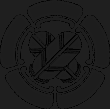

In [177]:
img_cv = tocv(img)

draw_cv = img_cv.copy()


sift = cv2.SIFT_create(32)
kp = sift.detect(draw_cv, None)
 
cv2.drawKeypoints(draw_cv, kp, draw_cv, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

topil(draw_cv)

### FAST

Docs: https://docs.opencv.org/4.x/df/d0c/tutorial_py_fast.html

In [ ]:
img_cv = tocv(img)

draw_cv = img_cv.copy()

fast = cv2.FastFeatureDetector_create(threshold=80)
kp = fast.detect(draw_cv, None)

cv2.drawKeypoints(draw_cv, kp, draw_cv, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

topil(draw_cv)